## 1. Import Libraries

In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

In [ ]:
!pip install feature_engine

In [ ]:
!pip install ydata-profiling[all]

## 2. Display Settings

In [3]:
pd.set_option("display.max_columns", None)

In [5]:
sklearn.set_config(transform_output="pandas")

In [7]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [10]:
path = r"C:\Users\vedan\Desktop\flight_price_pred\notebook\train.csv"
train = pd.read_csv(path)
train=train.dropna()
train.shape

(6694, 10)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6694 non-null   object 
 1   date_of_journey  6694 non-null   object 
 2   source           6694 non-null   object 
 3   destination      6694 non-null   object 
 4   dep_time         6694 non-null   object 
 5   arrival_time     6694 non-null   object 
 6   duration         6694 non-null   float64
 7   total_stops      6694 non-null   float64
 8   additional_info  6694 non-null   object 
 9   price            6694 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 523.1+ KB


In [14]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [17]:
X_train.airline

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6689    Jet Airways
6690      Air India
6691    Jet Airways
6692       Air Asia
6693      Air India
Name: airline, Length: 6694, dtype: object

In [19]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6689,0.0,0.0,1.0,0.0,0.0
6690,1.0,0.0,0.0,0.0,0.0
6691,0.0,0.0,1.0,0.0,0.0
6692,0.0,0.0,0.0,0.0,1.0


### 4.2 date_of_journey

In [22]:
X_train.date_of_journey

0       2019-03-21
1       2019-03-27
2       2019-03-09
3       2019-06-12
4       2019-03-12
           ...    
6689    2019-03-21
6690    2019-05-01
6691    2019-06-01
6692    2019-06-24
6693    2019-03-01
Name: date_of_journey, Length: 6694, dtype: object

In [24]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,0.000000,0.235294,0.333333,0.220339
2,0.000000,0.058824,0.833333,0.067797
3,1.000000,0.882353,0.333333,0.872881
4,0.000000,0.117647,0.166667,0.093220
...,...,...,...,...
6689,0.000000,0.176471,0.500000,0.169492
6690,0.666667,0.529412,0.333333,0.516949
6691,1.000000,0.764706,0.833333,0.779661
6692,1.000000,1.000000,0.000000,0.974576


### 4.3 source & destination

In [27]:
X_train.source

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6689       Delhi
6690     Kolkata
6691       Delhi
6692       Delhi
6693    Banglore
Name: source, Length: 6694, dtype: object

In [29]:
X_train.destination

0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6689       Cochin
6690     Banglore
6691       Cochin
6692       Cochin
6693    New Delhi
Name: destination, Length: 6694, dtype: object

In [31]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Banglore,New Delhi
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6689,Delhi,Cochin
6690,Kolkata,Banglore
6691,Delhi,Cochin
6692,Delhi,Cochin


In [33]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.857629,-0.736209
1,1.065619,1.061892
2,-0.857629,-0.736209
3,-0.203923,-0.224330
4,-0.857629,-0.736209
...,...,...
6689,1.065619,1.061892
6690,-0.203923,-0.224330
6691,1.065619,1.061892
6692,1.065619,1.061892


In [35]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [36]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6689,1,0
6690,1,0
6691,1,0
6692,1,0


In [37]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.857629,-0.736209,0,1
1,1.065619,1.061892,1,0
2,-0.857629,-0.736209,0,1
3,-0.203923,-0.224330,1,0
4,-0.857629,-0.736209,0,1
...,...,...,...,...
6689,1.065619,1.061892,1,0
6690,-0.203923,-0.224330,1,0
6691,1.065619,1.061892,1,0
6692,1.065619,1.061892,1,0


### 4.4 dep_time & arrival_time

In [40]:
X_train.dep_time

0       2024-06-23 08:55:00
1       2024-06-23 17:30:00
2       2024-06-23 11:40:00
3       2024-06-23 09:25:00
4       2024-06-23 22:55:00
               ...         
6689    2024-06-23 10:45:00
6690    2024-06-23 09:25:00
6691    2024-06-23 14:00:00
6692    2024-06-23 07:55:00
6693    2024-06-23 11:50:00
Name: dep_time, Length: 6694, dtype: object

In [41]:
X_train.arrival_time

0       2024-06-23 19:10:00
1       2024-06-23 04:25:00
2       2024-06-23 14:35:00
3       2024-06-23 18:30:00
4       2024-06-23 07:40:00
               ...         
6689    2024-06-23 18:50:00
6690    2024-06-23 18:30:00
6691    2024-06-23 19:00:00
6692    2024-06-23 13:25:00
6693    2024-06-23 08:55:00
Name: arrival_time, Length: 6694, dtype: object

In [42]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,2024-06-23 08:55:00,2024-06-23 19:10:00
1,2024-06-23 17:30:00,2024-06-23 04:25:00
2,2024-06-23 11:40:00,2024-06-23 14:35:00
3,2024-06-23 09:25:00,2024-06-23 18:30:00
4,2024-06-23 22:55:00,2024-06-23 07:40:00
...,...,...
6689,2024-06-23 10:45:00,2024-06-23 18:50:00
6690,2024-06-23 09:25:00,2024-06-23 18:30:00
6691,2024-06-23 14:00:00,2024-06-23 19:00:00
6692,2024-06-23 07:55:00,2024-06-23 13:25:00


In [43]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.826087,0.181818
1,0.739130,0.545455,0.173913,0.454545
2,0.478261,0.727273,0.608696,0.636364
3,0.391304,0.454545,0.782609,0.545455
4,0.956522,1.000000,0.304348,0.727273
...,...,...,...,...
6689,0.434783,0.818182,0.782609,0.909091
6690,0.391304,0.454545,0.782609,0.545455
6691,0.608696,0.000000,0.826087,0.000000
6692,0.304348,1.000000,0.565217,0.454545


In [50]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,evening,morning
2,morning,afternoon
3,morning,evening
4,night,morning
...,...,...
6689,morning,evening
6690,morning,evening
6691,afternoon,evening
6692,morning,afternoon


In [52]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.667335
1,0.202773,0.951904
2,1.000000,0.000000
3,1.000000,0.667335
4,0.174177,0.951904
...,...,...
6689,1.000000,0.667335
6690,1.000000,0.667335
6691,0.000000,0.667335
6692,1.000000,0.000000


In [53]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335
1,0.739130,0.545455,0.173913,0.454545,0.202773,0.951904
2,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000
3,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
4,0.956522,1.000000,0.304348,0.727273,0.174177,0.951904
...,...,...,...,...,...,...
6689,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335
6690,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
6691,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335
6692,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


### 4.5 duration

In [56]:
X_train.duration

0        615.00
1        655.00
2        175.00
3        545.00
4        525.00
         ...   
6689    1601.75
6690     545.00
6691     300.00
6692     330.00
6693    1265.00
Name: duration, Length: 6694, dtype: float64

In [57]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170.],
       [510.],
       [920.]])

In [58]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [59]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.0,1.000000,1.000000
1,0.000000e+00,0.0,1.000000,1.000000
2,0.000000e+00,0.0,0.904837,0.904837
3,0.000000e+00,0.0,1.000000,1.000000
4,0.000000e+00,0.0,1.000000,1.000000
...,...,...,...,...
6689,0.000000e+00,0.0,0.904837,0.904837
6690,0.000000e+00,0.0,1.000000,1.000000
6691,4.225900e-132,0.0,1.000000,1.000000
6692,7.187782e-28,0.0,1.000000,1.000000


In [60]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [61]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [62]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.364291,-0.107984,-0.092588,2.0,0,-0.019076
1,-0.364291,-0.107984,-0.092588,2.0,0,0.064286
2,2.372693,-0.107984,-0.092588,0.0,0,-0.936060
3,-0.364291,-0.107984,-0.092588,2.0,0,-0.164959
4,-0.364291,-0.107983,-0.092588,2.0,0,-0.206641
...,...,...,...,...,...,...
6689,-0.364291,-0.107984,-0.092588,2.0,1,2.037365
6690,-0.364291,-0.107984,-0.092588,2.0,0,-0.164959
6691,-0.364291,-0.107984,-0.092588,1.0,0,-0.675553
6692,-0.364291,-0.107984,-0.092588,1.0,0,-0.613031


### 4.6 total_stops

In [64]:
X_train.total_stops

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
6689    2.0
6690    1.0
6691    1.0
6692    1.0
6693    1.0
Name: total_stops, Length: 6694, dtype: float64

In [65]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
6689,2.0,0
6690,1.0,0
6691,1.0,0
6692,1.0,0


### 4.7 additional_info

In [77]:
X_train.additional_info

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6689                        No Info
6690                        No Info
6691    In-flight meal not included
6692                        No Info
6693                 1 Long layover
Name: additional_info, Length: 6694, dtype: object

In [79]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6689,0.0,1.0,0.0
6690,0.0,1.0,0.0
6691,1.0,0.0,0.0
6692,0.0,1.0,0.0


In [80]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [81]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [82]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6689,0.0,1.0,0.0,0
6690,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,1
6692,0.0,1.0,0.0,0


### 4.8 Column Transformer

In [86]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.857629,-0.736209,0,1,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335,-0.364291,-0.107984,-0.092588,2.0,0,-0.019076,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.065619,1.061892,1,0,0.739130,0.545455,0.173913,0.454545,0.202773,0.951904,-0.364291,-0.107984,-0.092588,2.0,0,0.064286,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.000000,0.058824,0.833333,0.067797,-0.857629,-0.736209,0,1,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000,2.372693,-0.107984,-0.092588,0.0,0,-0.936060,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.203923,-0.224330,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364291,-0.107984,-0.092588,2.0,0,-0.164959,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-0.857629,-0.736209,0,1,0.956522,1.000000,0.304348,0.727273,0.174177,0.951904,-0.364291,-0.107983,-0.092588,2.0,0,-0.206641,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.065619,1.061892,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335,-0.364291,-0.107984,-0.092588,2.0,1,2.037365,2.0,0,0.0,1.0,0.0,0
6690,1.0,0.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.203923,-0.224330,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364291,-0.107984,-0.092588,2.0,0,-0.164959,1.0,0,0.0,1.0,0.0,0
6691,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.065619,1.061892,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335,-0.364291,-0.107984,-0.092588,1.0,0,-0.675553,1.0,0,1.0,0.0,0.0,1
6692,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.065619,1.061892,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.364291,-0.107984,-0.092588,1.0,0,-0.613031,1.0,0,0.0,1.0,0.0,0


## 5. Feature Selection

In [88]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [94]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.176471,0.169492,-0.857629,-0.736209,-0.364291,2.0,0,-0.019076,1.0,0
1,0.0,1.0,0.0,0.235294,0.220339,1.065619,1.061892,-0.364291,2.0,0,0.064286,1.0,0
2,0.0,0.0,1.0,0.058824,0.067797,-0.857629,-0.736209,2.372693,0.0,0,-0.936060,0.0,1
3,0.0,0.0,0.0,0.882353,0.872881,-0.203923,-0.224330,-0.364291,2.0,0,-0.164959,1.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-0.857629,-0.736209,-0.364291,2.0,0,-0.206641,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,1.0,0.0,0.176471,0.169492,1.065619,1.061892,-0.364291,2.0,1,2.037365,2.0,0
6690,0.0,0.0,0.0,0.529412,0.516949,-0.203923,-0.224330,-0.364291,2.0,0,-0.164959,1.0,0
6691,0.0,1.0,0.0,0.764706,0.779661,1.065619,1.061892,-0.364291,1.0,0,-0.675553,1.0,0
6692,0.0,0.0,1.0,1.000000,0.974576,1.065619,1.061892,-0.364291,1.0,0,-0.613031,1.0,0


## 7. Visualizations

In [96]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.00204748830602682,
 'air__airline_Indigo': 0.12836215285886088,
 'air__airline_Jet Airways': 0.19344947492438477,
 'air__airline_Multiple Carriers': 0.019061382721082227,
 'air__airline_Other': 0.11846058299683764,
 'doj__date_of_journey_month': 0.0891930219053337,
 'doj__date_of_journey_week': 0.18545205813867202,
 'doj__date_of_journey_day_of_week': 0.005234570009364818,
 'doj__date_of_journey_day_of_year': 0.2271022061742051,
 'location__source': 0.12699498762521164,
 'location__destination': 0.1311104993210662,
 'location__source_is_north': 0.0804959336027441,
 'location__destination_is_north': 0.02964117275449485,
 'time__dep_time_hour': 0.0074911375594401974,
 'time__dep_time_minute': 0.03794149357137192,
 'time__arrival_time_hour': 0.08068284546718978,
 'time__arrival_time_minute': 0.031190920907649595,
 'time__dep_time_part_of_day': -0.0011295681198565388,
 'time__arrival_time_part_of_day': 0.0314661311801779,
 'dur__duration_rbf_25': 0.112060200039

In [97]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': -0.0011295681198565388,
 'info__additional_info_No Info': -0.0008149235823306326,
 'info__additional_info': -0.0008149235823306326,
 'info__additional_info_In-flight meal not included': 0.0017193556330226494,
 'dur__duration_rbf_75': 0.0018026908092185028,
 'air__airline_Air India': 0.00204748830602682,
 'doj__date_of_journey_day_of_week': 0.005234570009364818,
 'dur__duration_rbf_50': 0.006210480204055087,
 'time__dep_time_hour': 0.0074911375594401974,
 'info__additional_info_Other': 0.01778001687368147,
 'air__airline_Multiple Carriers': 0.019061382721082227,
 'location__destination_is_north': 0.02964117275449485,
 'time__arrival_time_minute': 0.031190920907649595,
 'time__arrival_time_part_of_day': 0.0314661311801779,
 'time__dep_time_minute': 0.03794149357137192,
 'location__source_is_north': 0.0804959336027441,
 'time__arrival_time_hour': 0.08068284546718978,
 'doj__date_of_journey_month': 0.0891930219053337,
 'dur__duration_rbf_25': 0.11206020003948

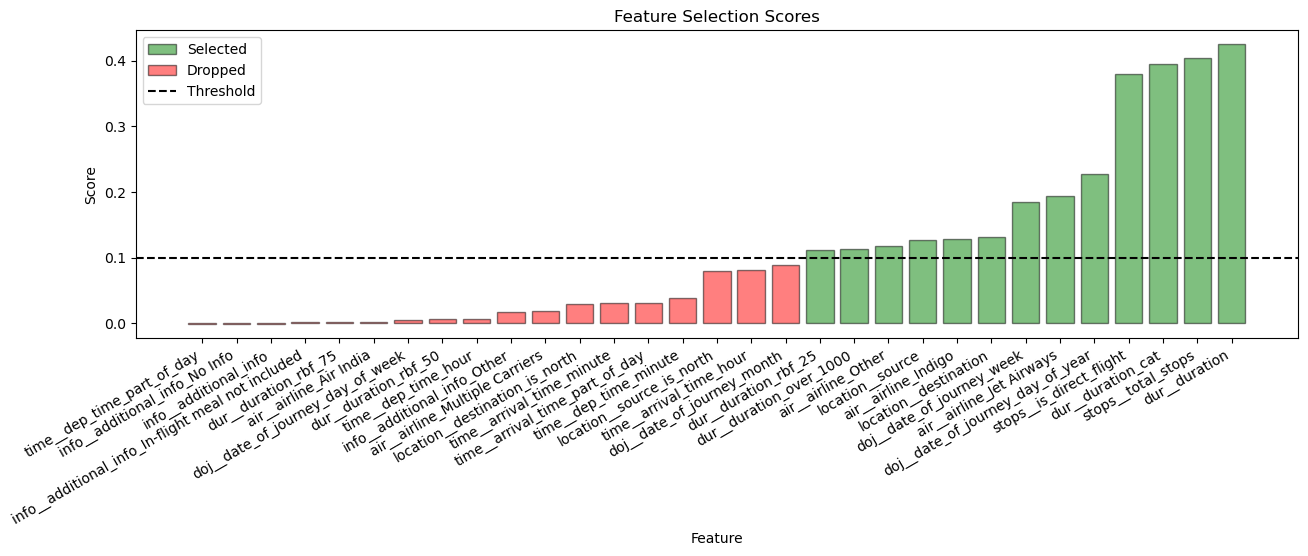

In [98]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that